<a id='top'></a>
# Analys av COVID-19 i Sverige

All data kommer från [Folkhälsomyndigheten](https://www.folkhalsomyndigheten.se/smittskydd-beredskap/utbrott/aktuella-utbrott/covid-19/bekraftade-fall-i-sverige/).

Folkhälsomyndigheten visar sin statistik [här](https://experience.arcgis.com/experience/09f821667ce64bf7be6f9f87457ed9aa).

### Innehållsförteckning
1. [Antal fall över tid](#antal_fall_över_tid)
2. [Fördelning av sjukdomsfall](#sjukdomsutfall)
3. [Förändring av sjukdomsfall över tid](#derivative)
4. [Pandemiutveckling](#trajectory)

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_excel("Folkhalsomyndigheten_Covid19.xlsx")
dfi = df.set_index('Statistikdatum')


<a id='antal_fall_över_tid'></a>
## Antal fall över tid

[Tillbaka till början](#top)

Text(0.06, 0.5, 'Number of cases')

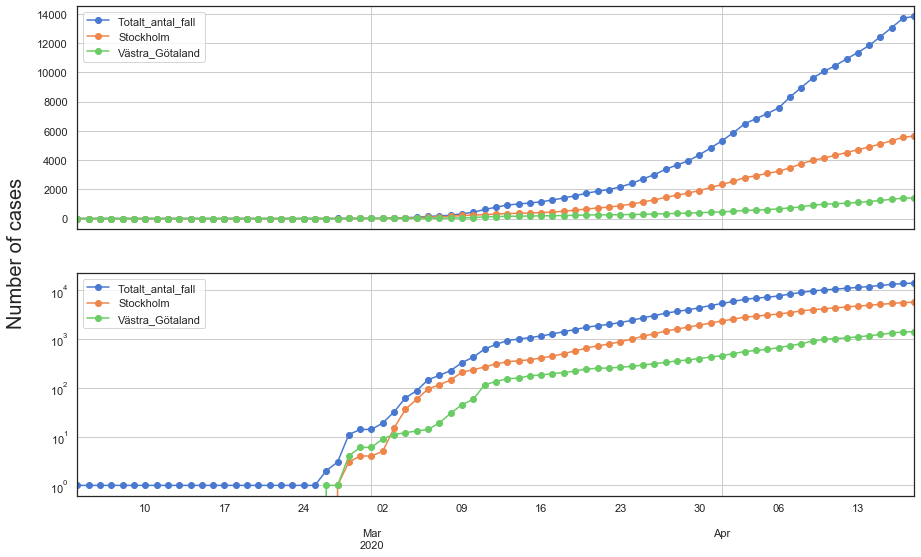

In [91]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,9))

y = [
    'Totalt_antal_fall',
    'Stockholm',
    'Västra_Götaland',
#     'Sörmland',
]
dfi.cumsum().plot(y=y, style='-o', grid=True, logy=False, ax=ax1)
dfi.cumsum().plot(y=y, style='-o', grid=True, logy=True, ax=ax2)

ax2.set_xlabel('')
fig.text(0.06, 0.5, 'Number of cases', va='center', rotation='vertical', fontsize=20)

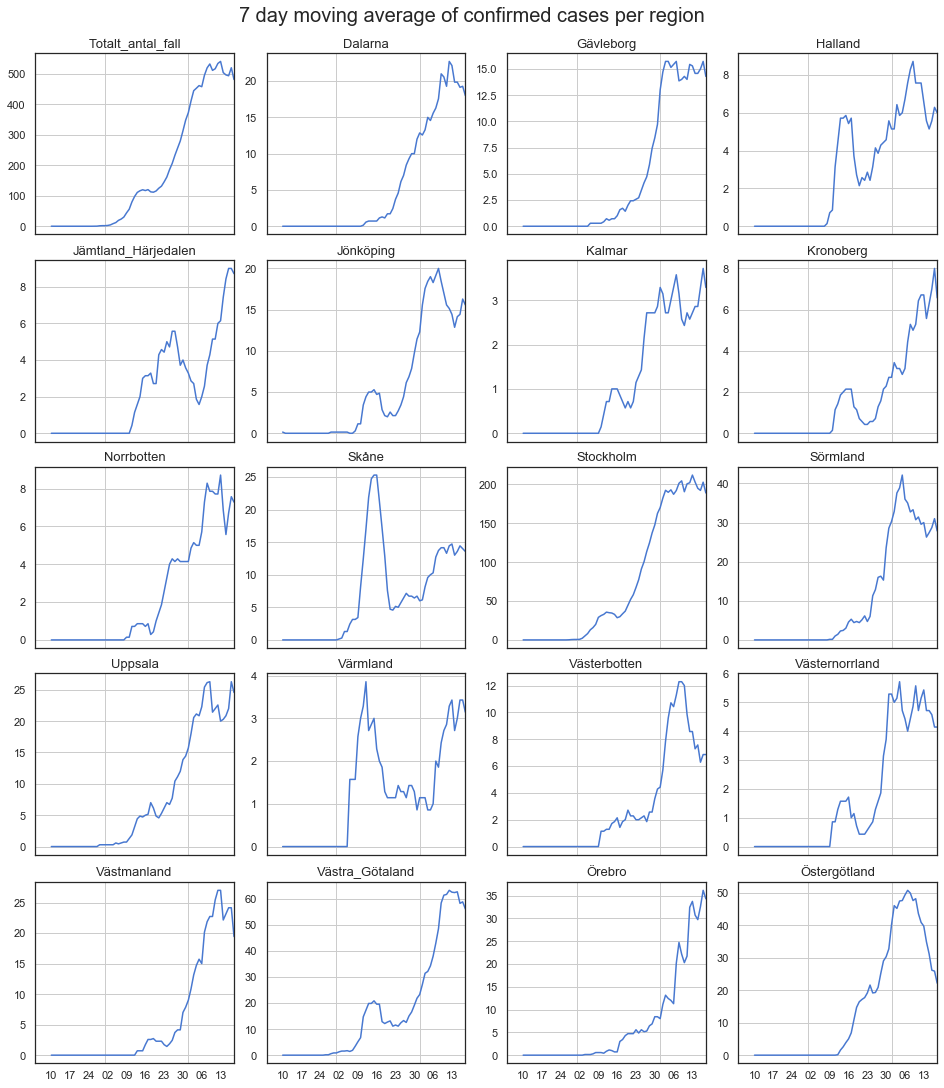

In [92]:
regions = [
    "Totalt_antal_fall",
#     "Blekinge",
    "Dalarna",
#     "Gotland",
    "Gävleborg",
    "Halland",
    "Jämtland_Härjedalen",
    "Jönköping",
    "Kalmar",
    "Kronoberg",
    "Norrbotten",
    "Skåne",
    "Stockholm",
    "Sörmland",
    "Uppsala",
    "Värmland",
    "Västerbotten",
    "Västernorrland",
    "Västmanland",
    "Västra_Götaland",
    "Örebro",
    "Östergötland"]

nrows = 5
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(13,15), constrained_layout=True, sharex=True)
axes = np.reshape(axes, -1)

window = 7
# fig.tight_layout()
fig.suptitle(f'{window} day moving average of confirmed cases per region', fontsize=20)
for region, ax in zip(regions, axes):
    df_temp = dfi[region].rolling(window).mean()
    df_temp.plot(grid=True, ax=ax)
    ax.set_title(region, fontsize=13)
    
    ax.set_xlabel('')
    ax.set_xticklabels('')


<a id='sjukdomsutfall'></a>
## Fördelning av sjukdomsutfall

[Tillbaka till början](#top)

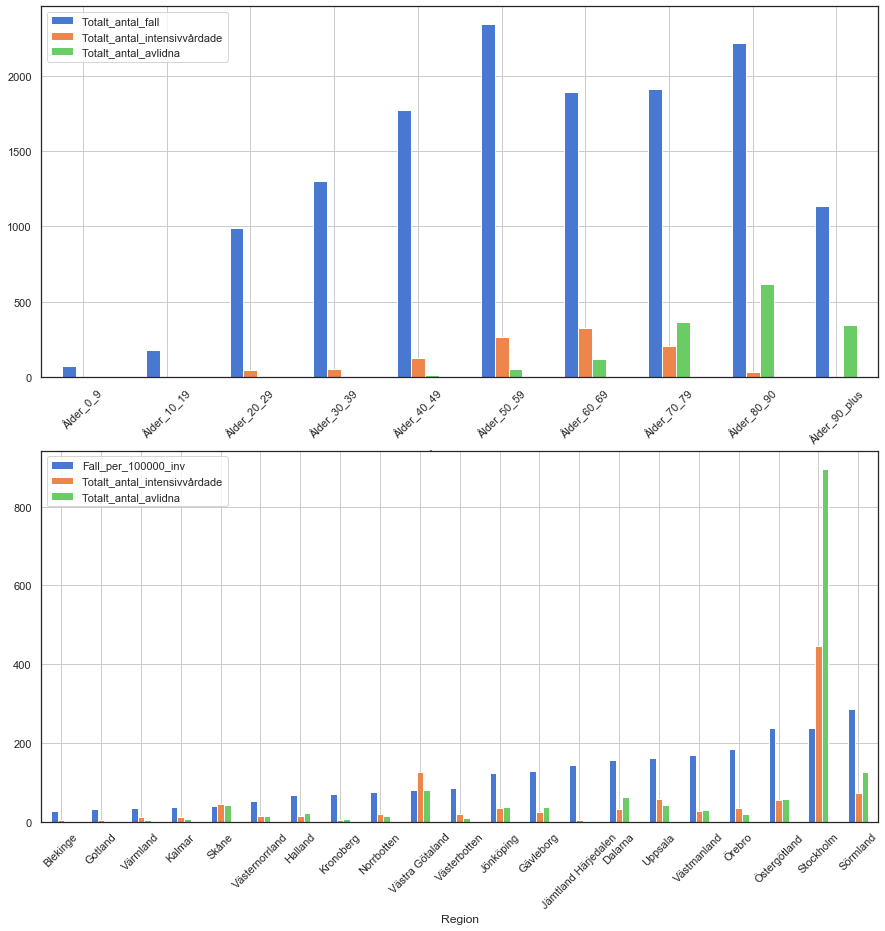

In [21]:
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)

df_age = pd.read_excel("Folkhalsomyndigheten_Covid19.xlsx", sheet_name=5)
df_age = df_age.iloc[:-1]
df_age.set_index('Åldersgrupp', inplace=True)



fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,15))

p = df_age.plot(kind='bar', grid=True, ax=ax1, rot=45)

df_region = pd.read_excel("Folkhalsomyndigheten_Covid19.xlsx", sheet_name=3)
df_region.set_index('Region', inplace=True)
df_region.drop('Totalt_antal_fall', axis=1).sort_values(by=['Fall_per_100000_inv']).plot(kind='bar', grid=True, ax=ax2, rot=45)

Text(0.5, 0, '')

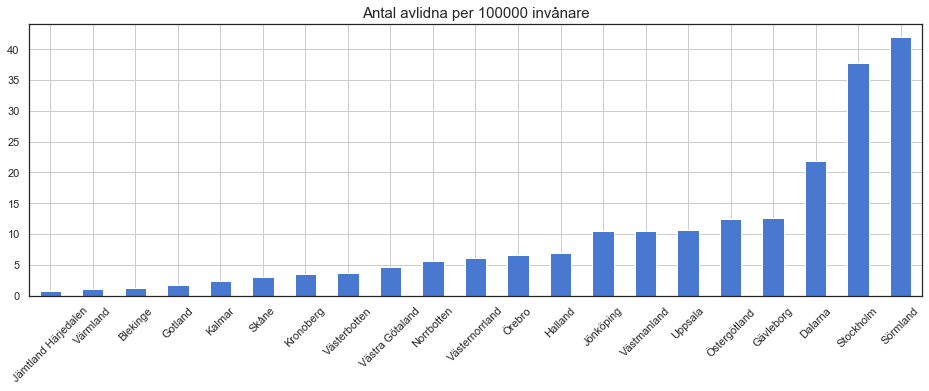

In [44]:
df_avlidna = df_region['Totalt_antal_avlidna']*df_region['Fall_per_100000_inv']/df_region['Totalt_antal_fall']
df_avlidna.name = 'Avlidna_per_100000_inv'
df_avlidna.head()
ax = df_avlidna.sort_values().plot(kind='bar', grid=True, figsize=(16,5), rot=45)
ax.set_title('Antal avlidna per 100000 invånare', fontsize=15)
ax.set_xlabel('')

<a id='derivative'></a>
## Förändring av sjukdomsfall över tid

[Tillbaka till början](#top)

<a id='trajectory'></a>
## Pandemiutveckling

Denna beräkningen är tagen från youtubekanalen [minutephysics](https://www.youtube.com/watch?v=54XLXg4fYsc)

[Tillbaka till början](#top)

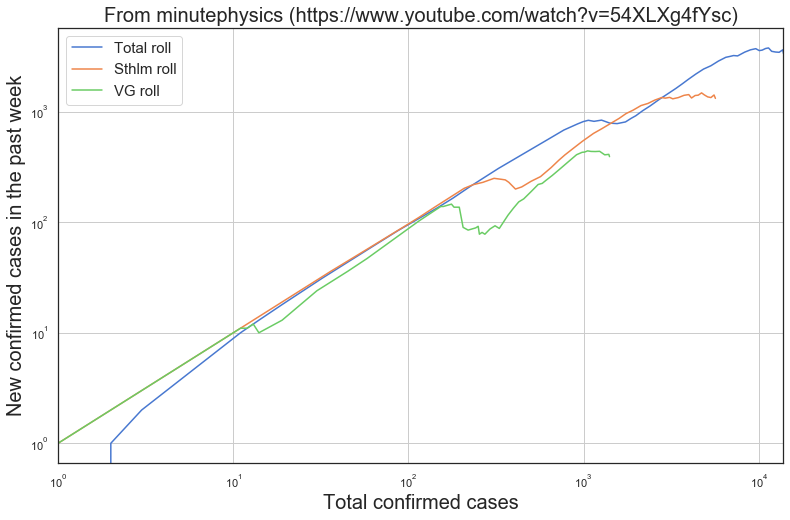

In [95]:
minutephysics = "https://www.youtube.com/watch?v=54XLXg4fYsc"
cols = ['Totalt_antal_fall', 'Stockholm', 'Västra_Götaland']
df_mp = df[cols]
df_mp.loc[:,'sthlm_roll'] = df_mp['Stockholm'].rolling(7).sum()
df_tmp = df_mp[cols].rolling(7).sum()
df_tmp.columns = ['Total roll', 'Sthlm roll', 'VG roll']
df_roll = pd.concat([df_mp.cumsum(), df_tmp], axis=1, sort=False)

fig, ax = plt.subplots(figsize=(13,8))
df_roll.plot(x='Totalt_antal_fall', y='Total roll', grid=True, loglog=True, ax=ax)
df_roll.plot(x='Stockholm', y='Sthlm roll', grid=True, loglog=True, ax=ax)
df_roll.plot(x='Västra_Götaland', y='VG roll', grid=True, loglog=True, ax=ax)

ax.set_ylabel('New confirmed cases in the past week', fontsize=20)
ax.set_xlabel('Total confirmed cases', fontsize=20)
ax.set_title(f"From minutephysics ({minutephysics})", fontsize=20)
ax.legend(fontsize=15)
